# SARIMA

The goal of this notebook is fitting a SARIMA model,
$$ \Phi_P(B^P) \phi_p(B^s) \nabla_s^D \nabla^d X_t = \Theta_Q(B^s) \theta_p(B) Y_t,$$
where

$$ \begin{array}{rcl}
\Phi_P(B) &=& 1 - \Phi_1 B - \Phi_2 B^2 - \dotsb - \Phi_P B^P, \\
\phi_p(B) &=& 1 - \phi_1 B - \phi_2 B^2 - \dotsb - \phi_p B^p, \\
\Theta_Q(B) &=& 1 + \Theta_1 B + \Theta_2 B^2 + \dotsb + \Theta_Q B^Q, \\
\theta_q(B) &=& 1 + \theta_1 B + \theta_2 B^2 + \dotsb + \theta_q B^q, \\
\nabla &=& 1 - B, \\
\nabla_s &=& 1 - B^s.
\end{array}$$

#  Table of contents
* [Parameter estimation](#param_est)
    * [Determinig $d$ and $D$](#ds)
    * [Determining $p$ and $q$](#pq)
    * [Determining $P$ and $Q$](#PQ)
* [Model prososals](#model_prop)

In [1]:
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
train = pd.read_parquet("../data/03_train-test/summed_data_train.parquet")
test = pd.read_parquet("../data/03_train-test/summed_data_test.parquet")
train

,tsd
settlement_date,
2009-01-01,1849363.0
2009-01-02,1974406.0
2009-01-03,1952054.0
2009-01-04,1968670.0
2009-01-05,2271471.0
...,...
2020-12-27,1361108.0
2020-12-28,1540561.0
2020-12-29,1591958.0


In [4]:
ts = pd.DataFrame(train['tsd'])
ts

,tsd
settlement_date,
2009-01-01,1849363.0
2009-01-02,1974406.0
2009-01-03,1952054.0
2009-01-04,1968670.0
2009-01-05,2271471.0
...,...
2020-12-27,1361108.0
2020-12-28,1540561.0
2020-12-29,1591958.0


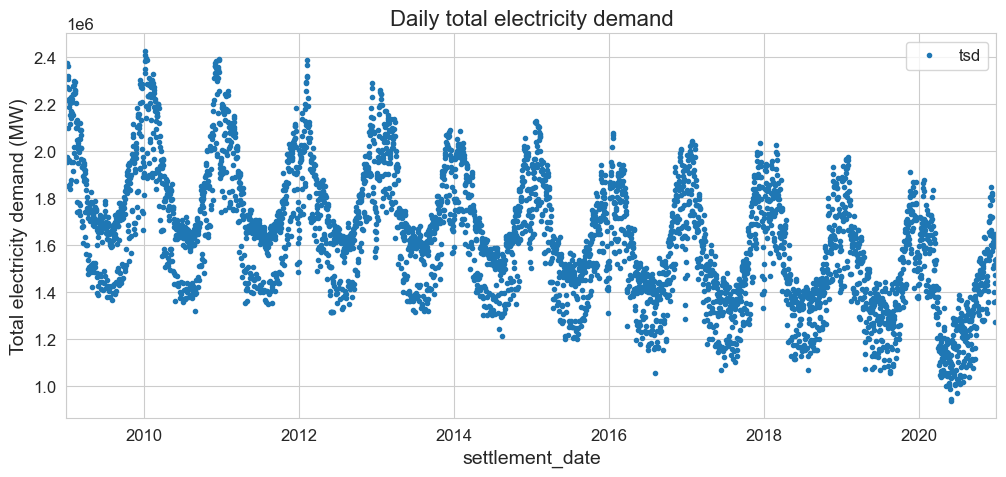

In [5]:
ts.plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

We start adding 1-day and 1-year lags and plotting what we obtain.

In [6]:
ts["lag_day"] = ts["tsd"].shift(1)
ts["lag_year"] = ts["tsd"].shift(364)


ts["difference_day"] = ts["tsd"] - ts["lag_day"]
ts["difference_year"] = ts["tsd"] - ts["lag_year"]
ts

,tsd,lag_day,lag_year,difference_day,difference_year
settlement_date,,,,,
2009-01-01,1849363.0,NaN,NaN,NaN,NaN
2009-01-02,1974406.0,1849363.0,NaN,125043.0,NaN
2009-01-03,1952054.0,1974406.0,NaN,-22352.0,NaN
2009-01-04,1968670.0,1952054.0,NaN,16616.0,NaN
2009-01-05,2271471.0,1968670.0,NaN,302801.0,NaN
...,...,...,...,...,...
2020-12-27,1361108.0,1270906.0,1373539.0,90202.0,-12431.0
2020-12-28,1540561.0,1361108.0,1524894.0,179453.0,15667.0
2020-12-29,1591958.0,1540561.0,1545611.0,51397.0,46347.0


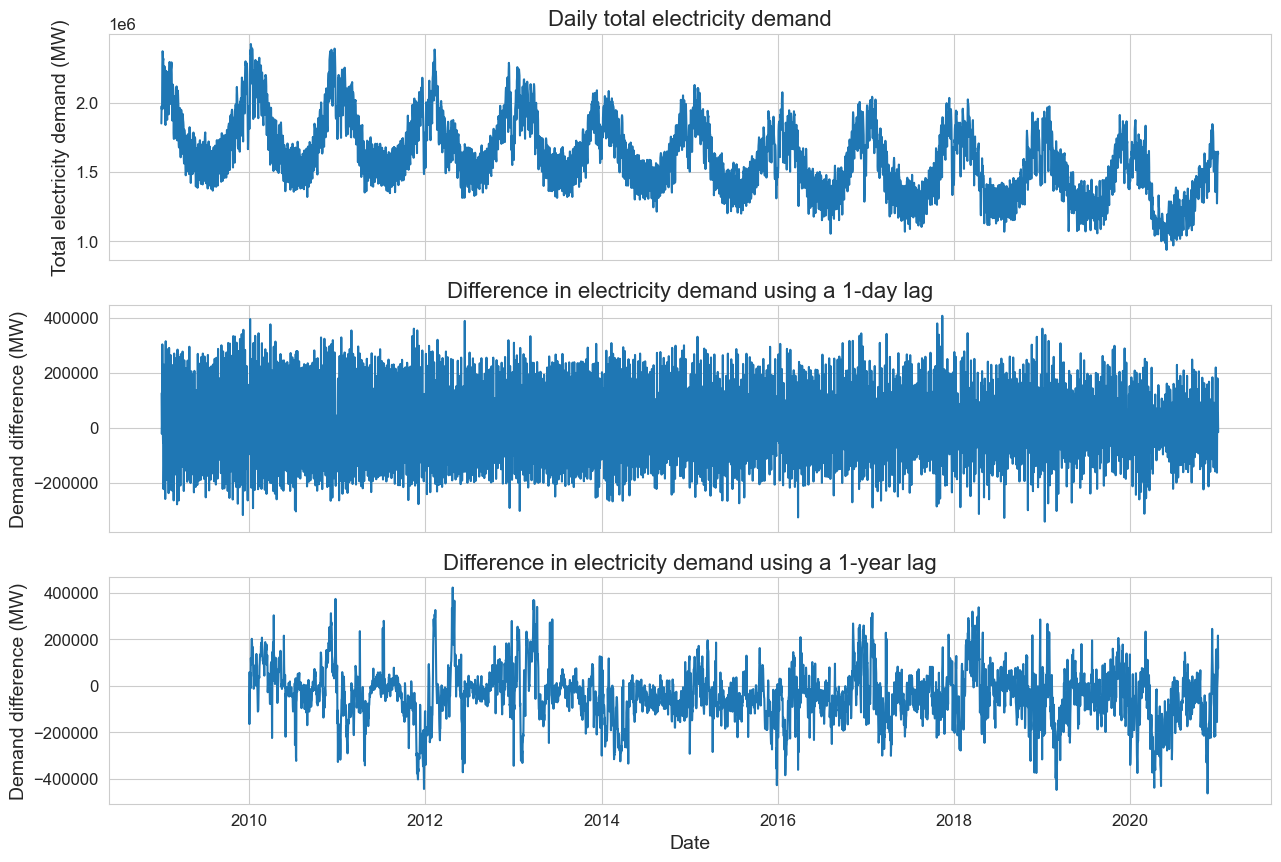

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(ts.index, ts["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")

axes[1].plot(ts.index, ts["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")

axes[2].plot(ts.index, ts["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

<a id='param_est'></a>
## Parameter estimation

<a id='ds'></a>
### Determining $d$ and $D$

In [8]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series train
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(timeseries)
    
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(train, lags=None):
    """
    Plot raw train, autocorreltion plot and partial autocorrelation plot

    Args:
        - train: time series train
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(train)
    sm.graphics.plot_acf(train, lags=lags, ax=acf, zero=False, auto_ylims=True)
    sm.graphics.plot_pacf(train, lags=lags, ax=pacf, zero=False, auto_ylims=True, method="ywm")
    sns.despine()
    plt.tight_layout()

We start checking the results of the _Aumented Dickey-Fuller test_, where the null hypothesis is
$$H_0: X_t \text{ is non stacionary} $$

Test Statistic            -4.091559
p-value                    0.001000
Lags Used                 28.000000
Observations Used       4354.000000
Critical Value (1%)       -3.431853
Critical Value (5%)       -2.862204
Critical Value (10%)      -2.567123
dtype: float64


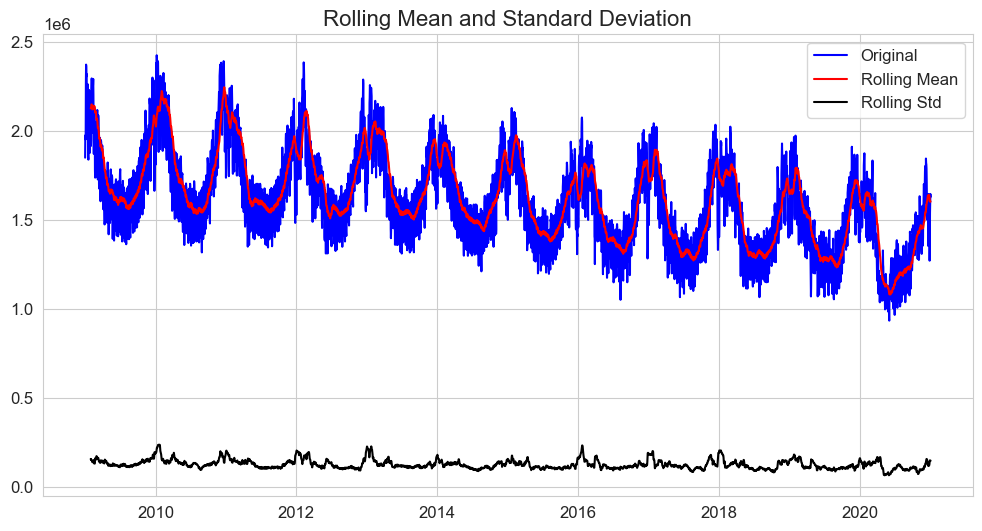

In [9]:
dftest(ts["tsd"], 30)

According to the test statistics and the p-value, the time series is stationary. Nevertheless, the plot show seasonality and a trend, so the time series is **not stationary**.

Now, we will look at the 1-day difference train.

Test Statistic         -1.348943e+01
p-value                 3.127176e-25
Lags Used               2.700000e+01
Observations Used       4.354000e+03
Critical Value (1%)    -3.431853e+00
Critical Value (5%)    -2.862204e+00
Critical Value (10%)   -2.567123e+00
dtype: float64


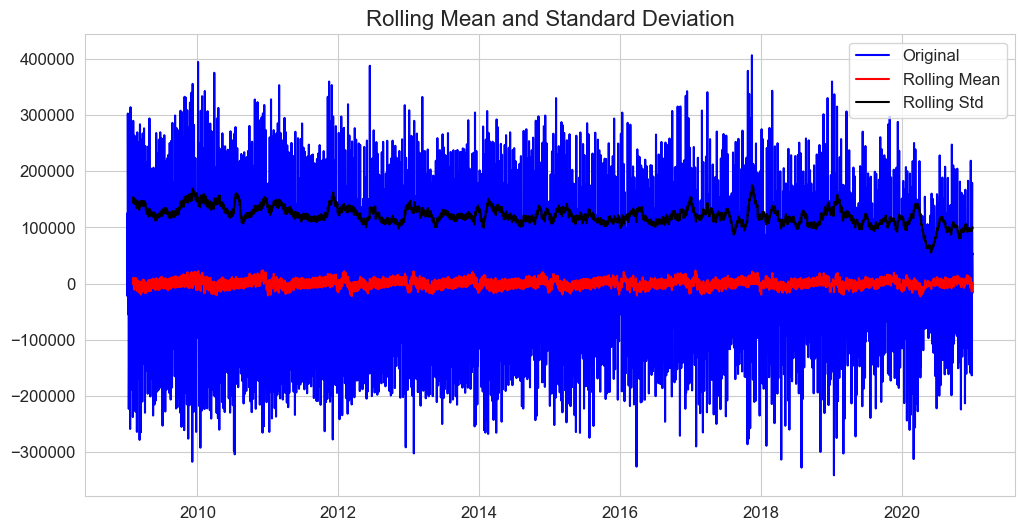

In [10]:
dftest(ts["difference_day"].dropna(), 30)

In this case, with the test we obtain that the series is stationary and if we look the plot, we see that we have removed the trend component. So we choose, $d=1$ for our model.

The next step is to determine $D$. To do so, we will decompose the series.

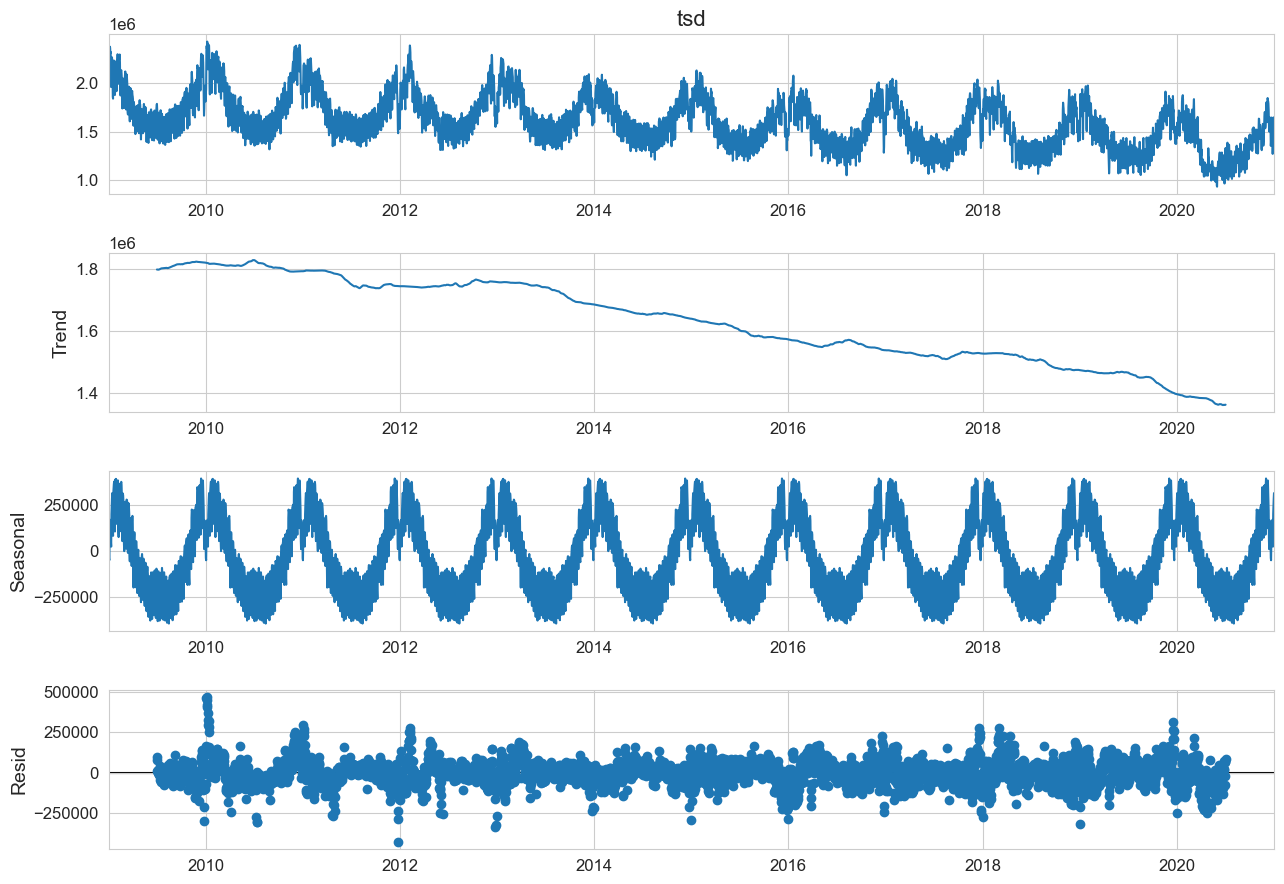

In [11]:
decompose = sm.seasonal_decompose(ts["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

We check if the seasonal component is stationary:

Test Statistic            -4.196271
p-value                    0.000669
Lags Used                 30.000000
Observations Used       4352.000000
Critical Value (1%)       -3.431853
Critical Value (5%)       -2.862204
Critical Value (10%)      -2.567124
dtype: float64


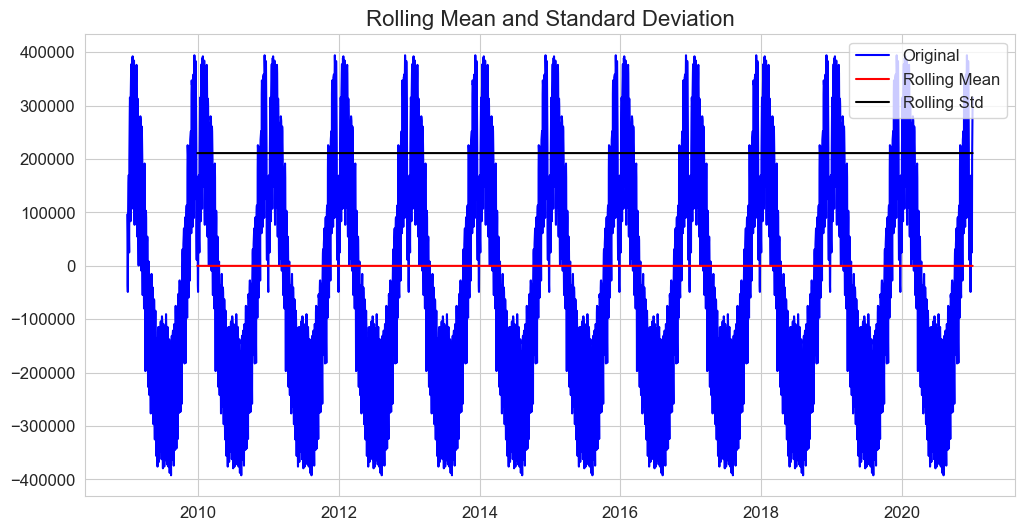

In [12]:
dftest(decompose.seasonal, 364)

Test Statistic         -1.053453e+01
p-value                 8.972348e-19
Lags Used               1.000000e+01
Observations Used       4.008000e+03
Critical Value (1%)    -3.431983e+00
Critical Value (5%)    -2.862261e+00
Critical Value (10%)   -2.567154e+00
dtype: float64


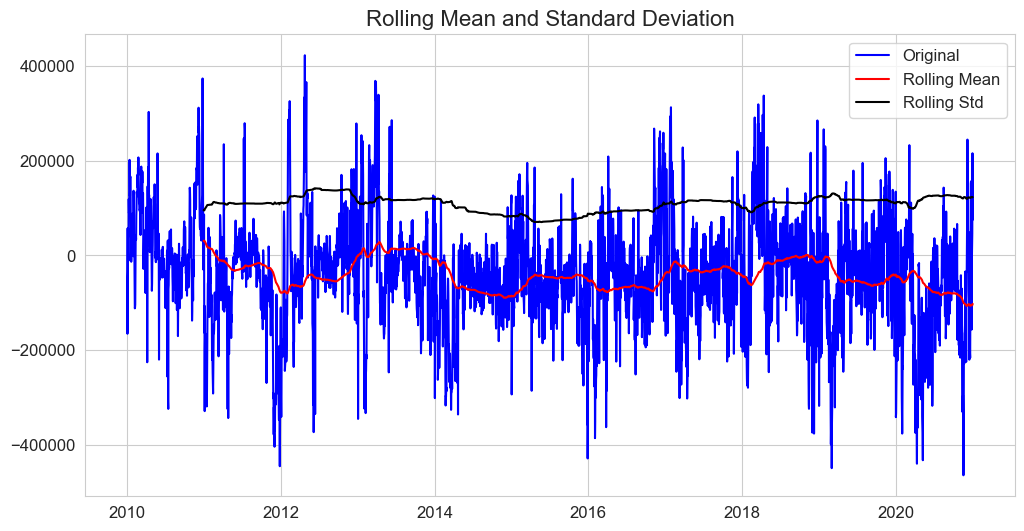

In [13]:
dftest(ts["difference_year"].dropna(), 364)

Since the 1-year differenced train is stationary, $D=1$.

<a id='pq'></a>
### Determining $p$ and $q$

We define a new time series $W_t = \nabla \nabla_s X_t$.

In [14]:
s = 364
w = ts['tsd'] - ts['tsd'].shift(1) - ts['tsd'].shift(s) + ts['tsd'].shift(s+1)
w = w.dropna()

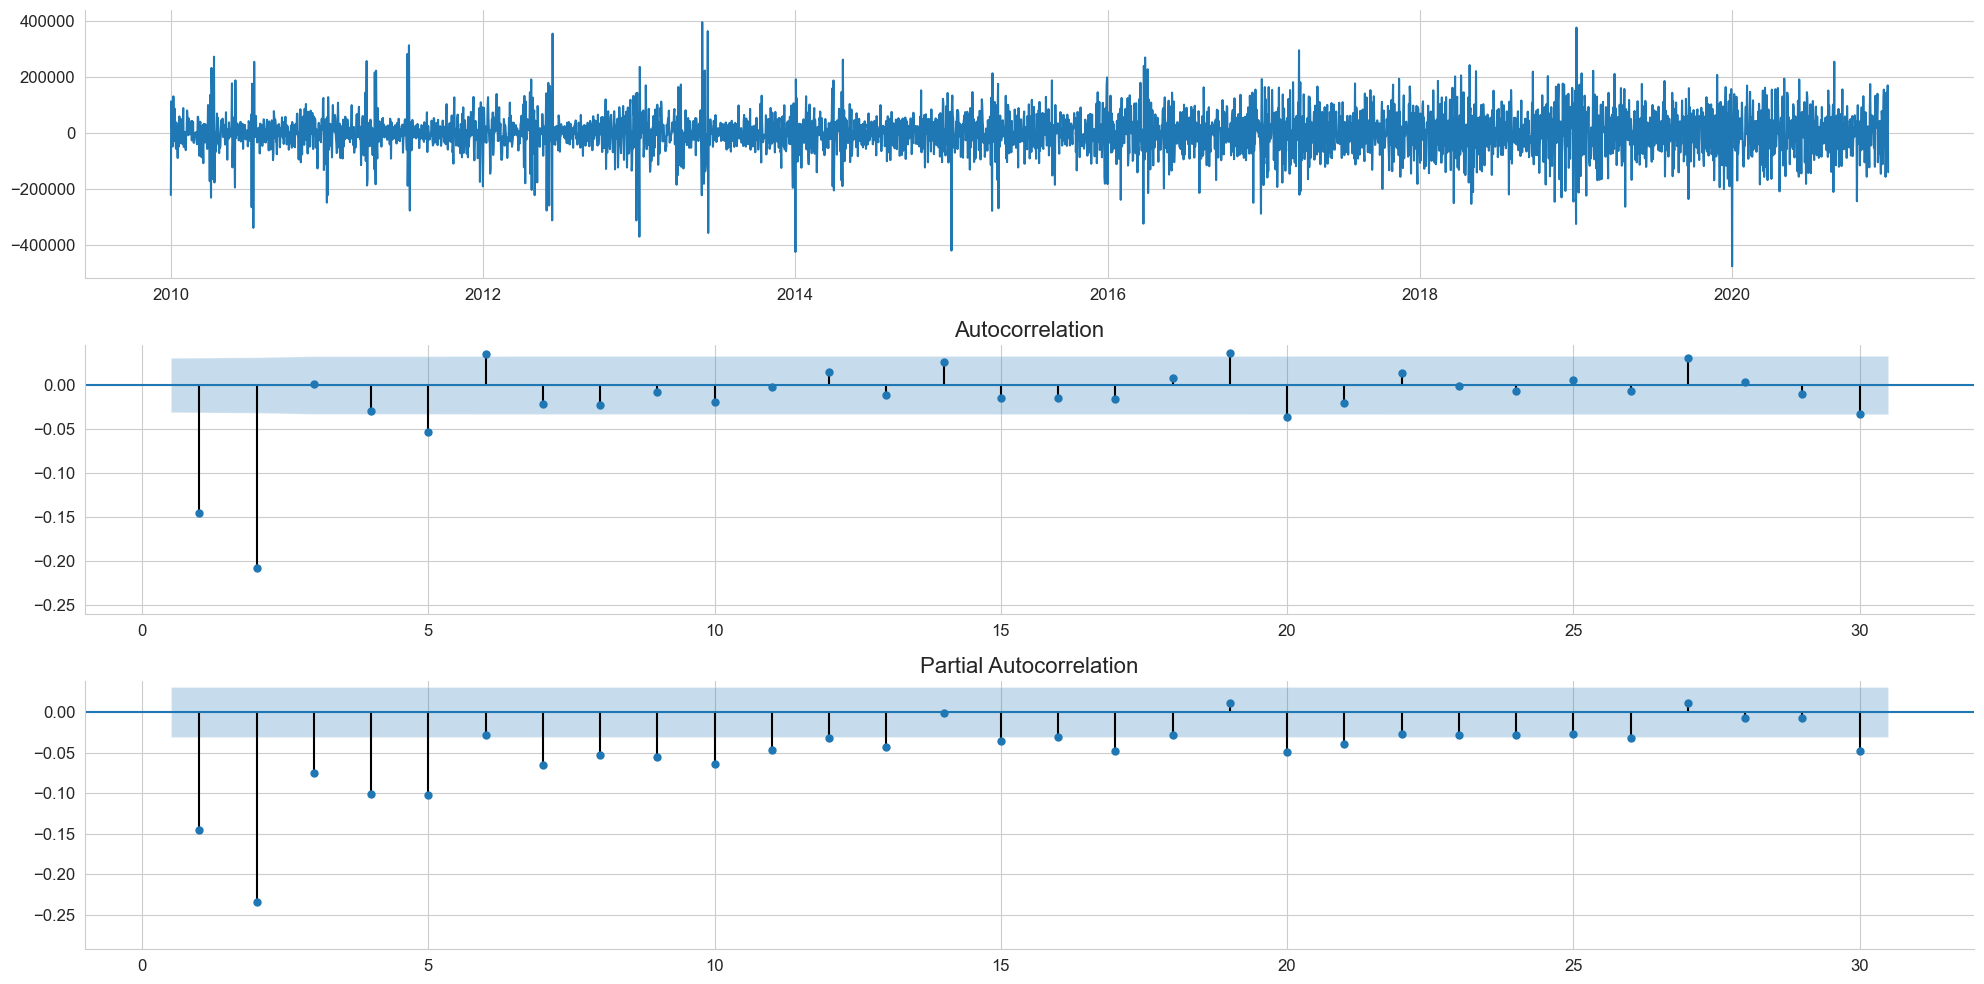

In [15]:
autocorr_plots(w, lags=30)

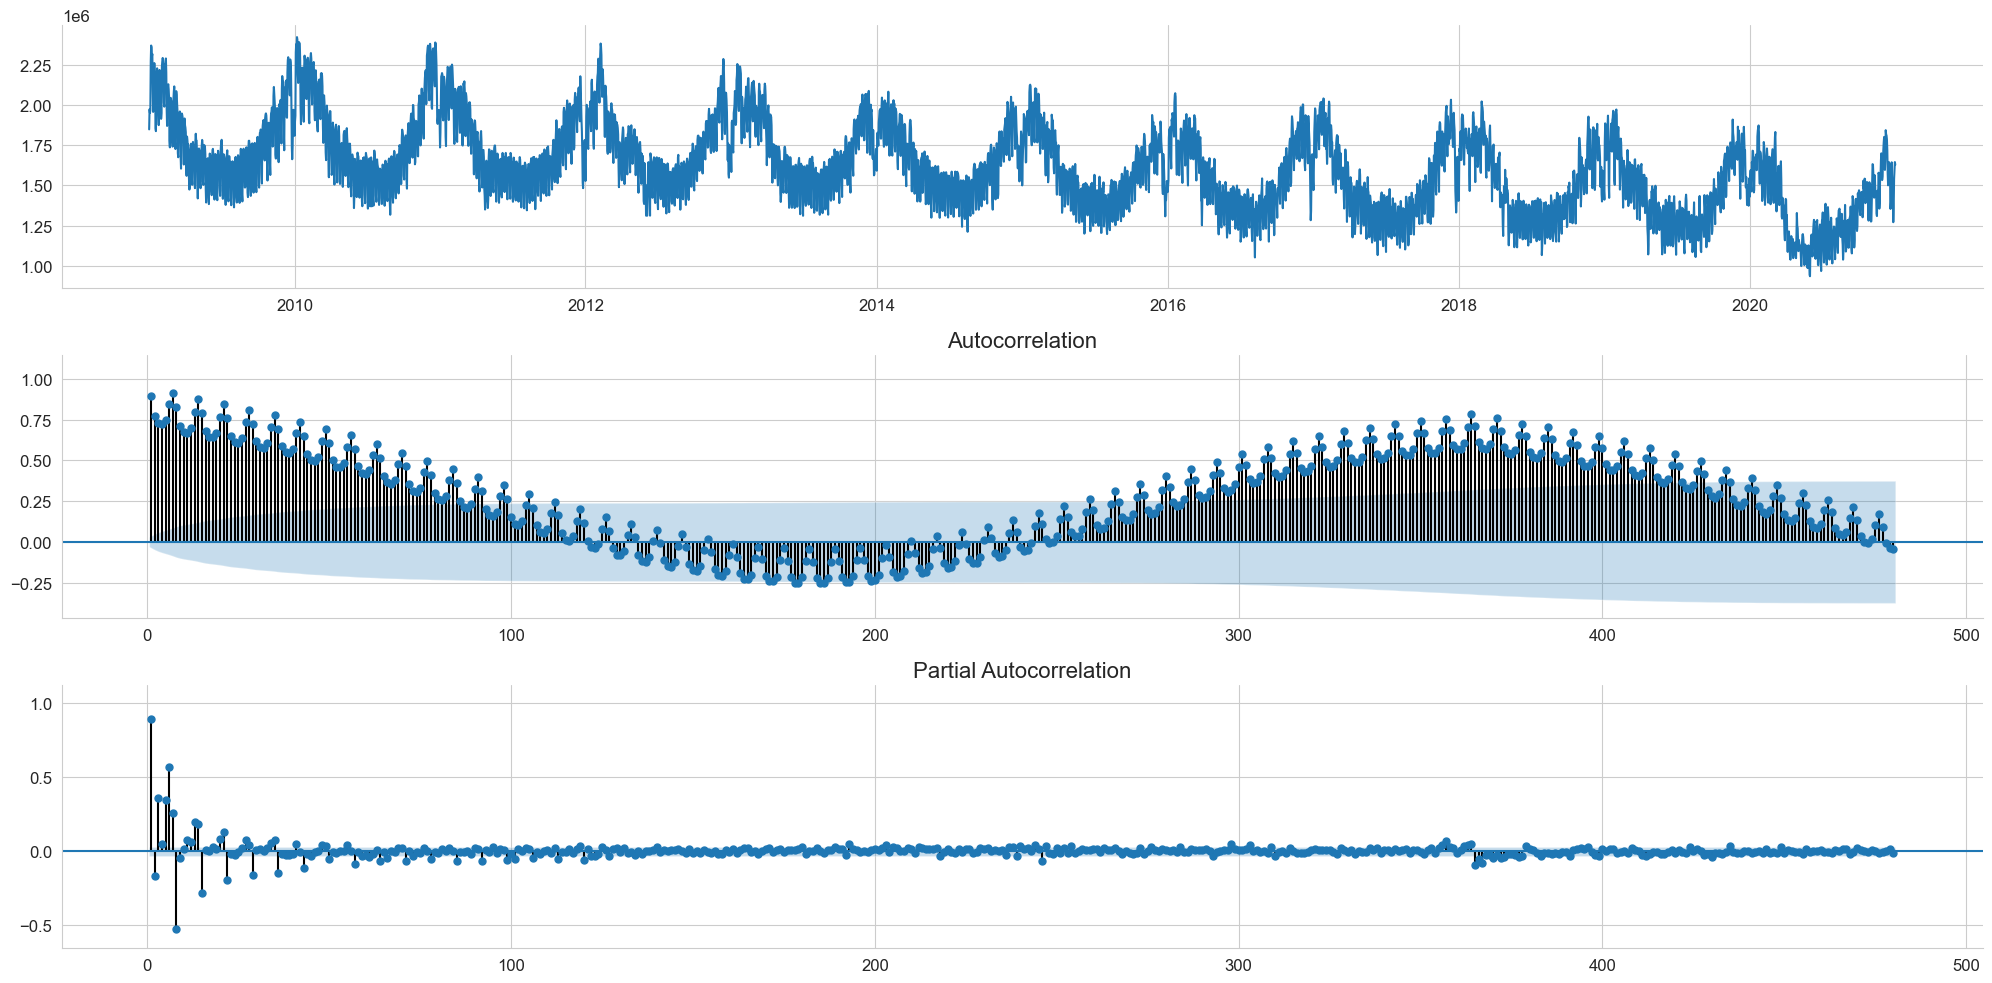

In [16]:
autocorr_plots(ts["tsd"], lags=480)

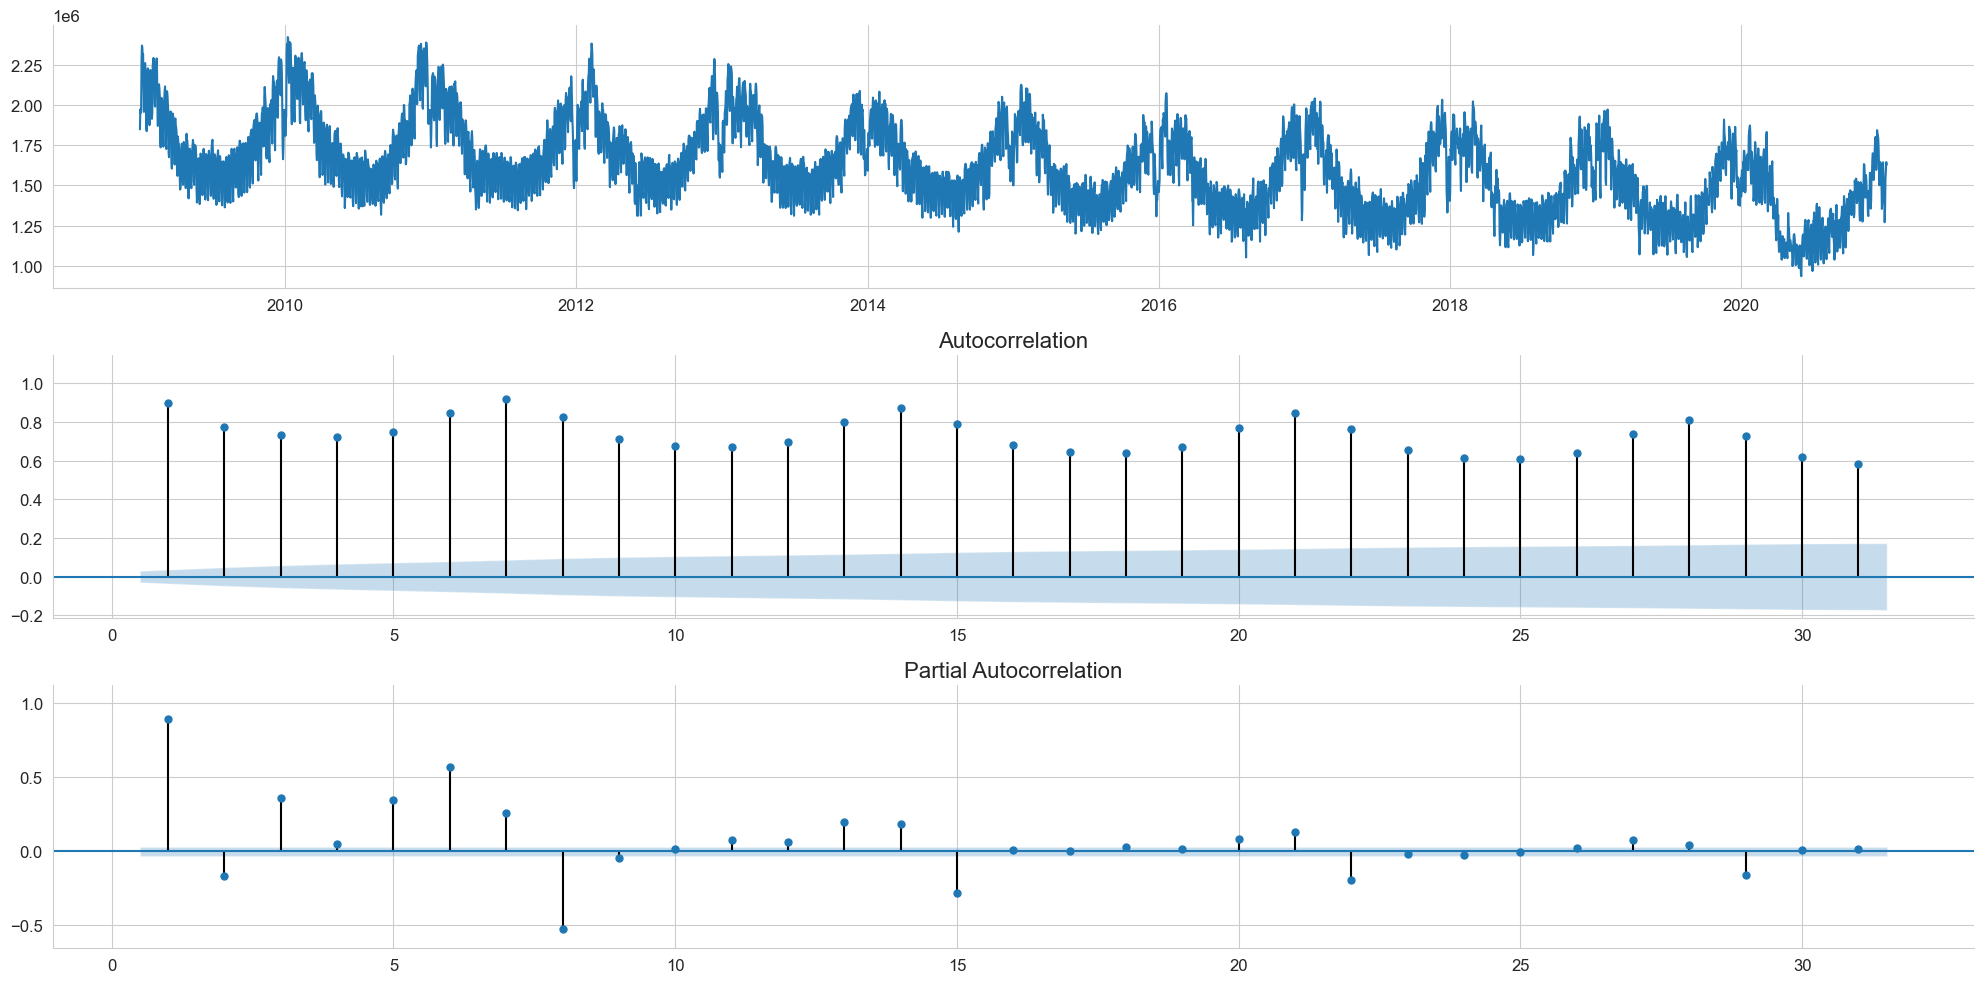

In [17]:
autocorr_plots(ts["tsd"], lags=31)

We can see that there is yearly seasonality, but there is algo weekly seasonality. We choose $p=7$ and $q=2$.

<a id='PQ'></a>
### Determining P and Q

We can use the 1-year differenced values to estimate the seasonal parameters:

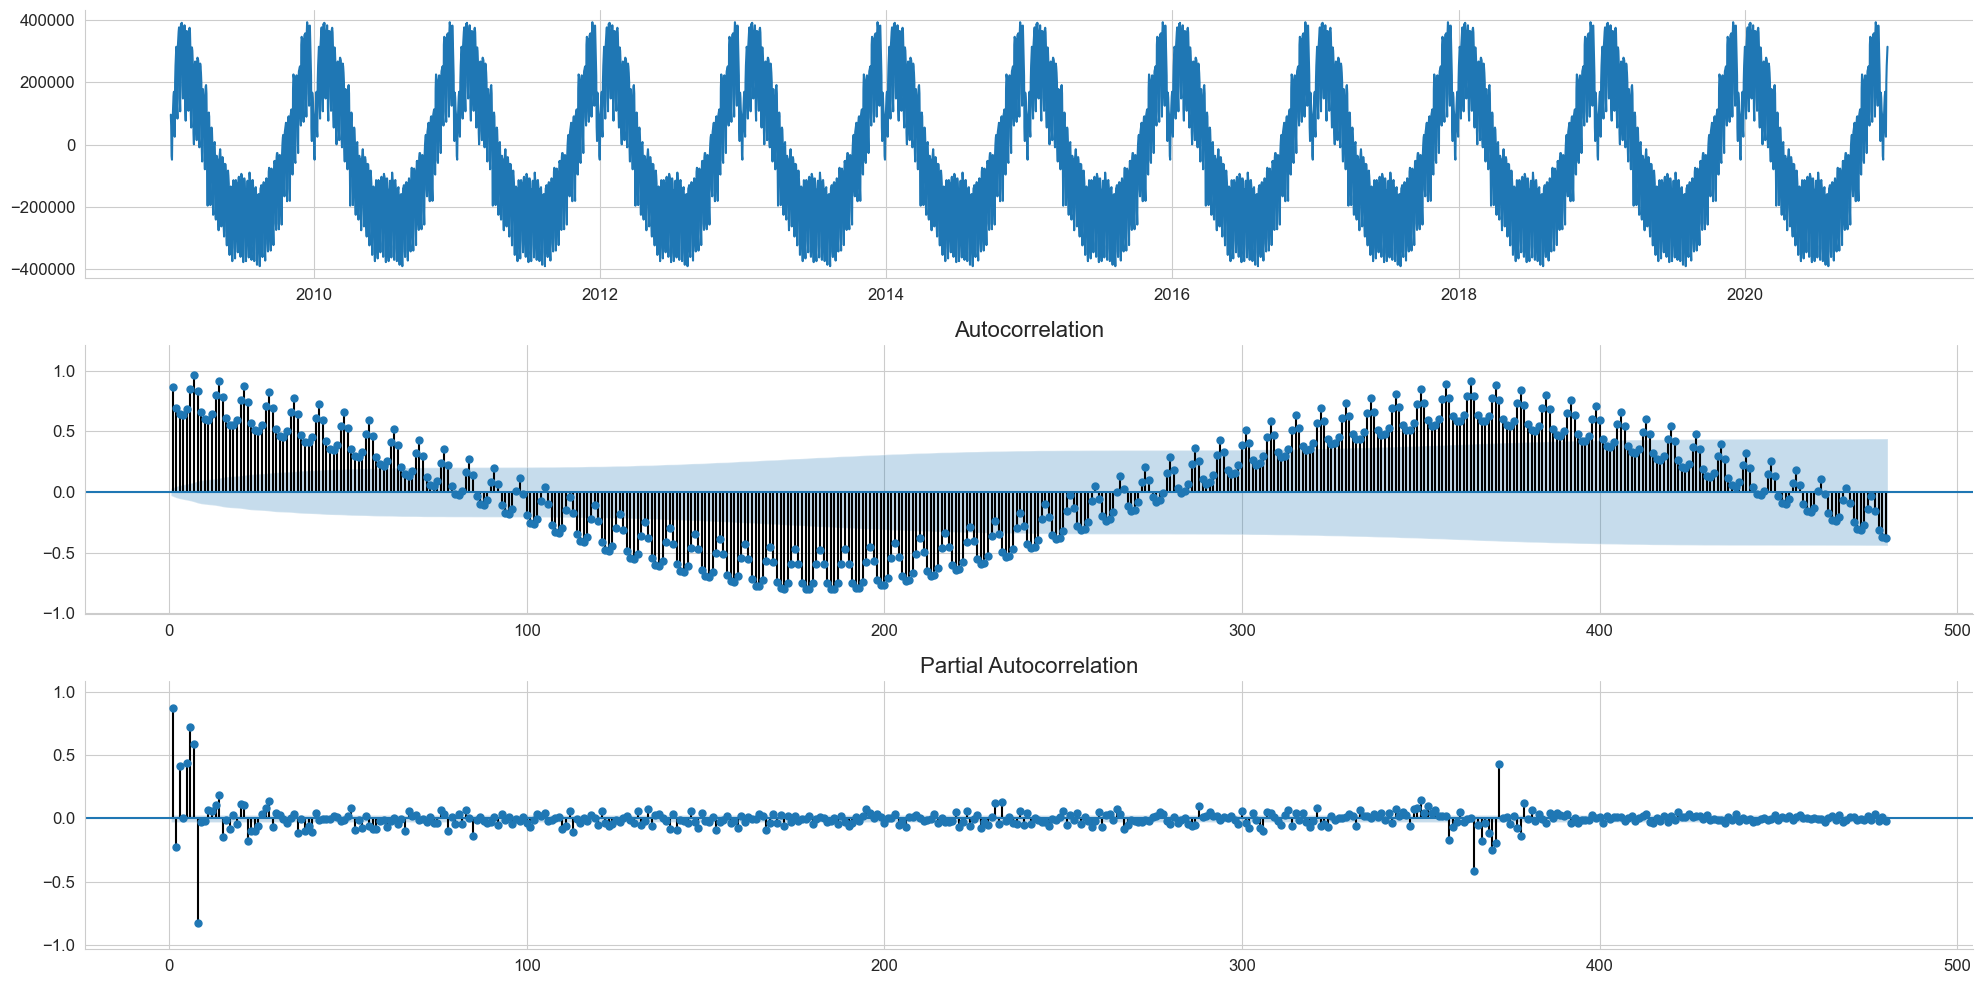

In [18]:
autocorr_plots(decompose.seasonal, lags=480)

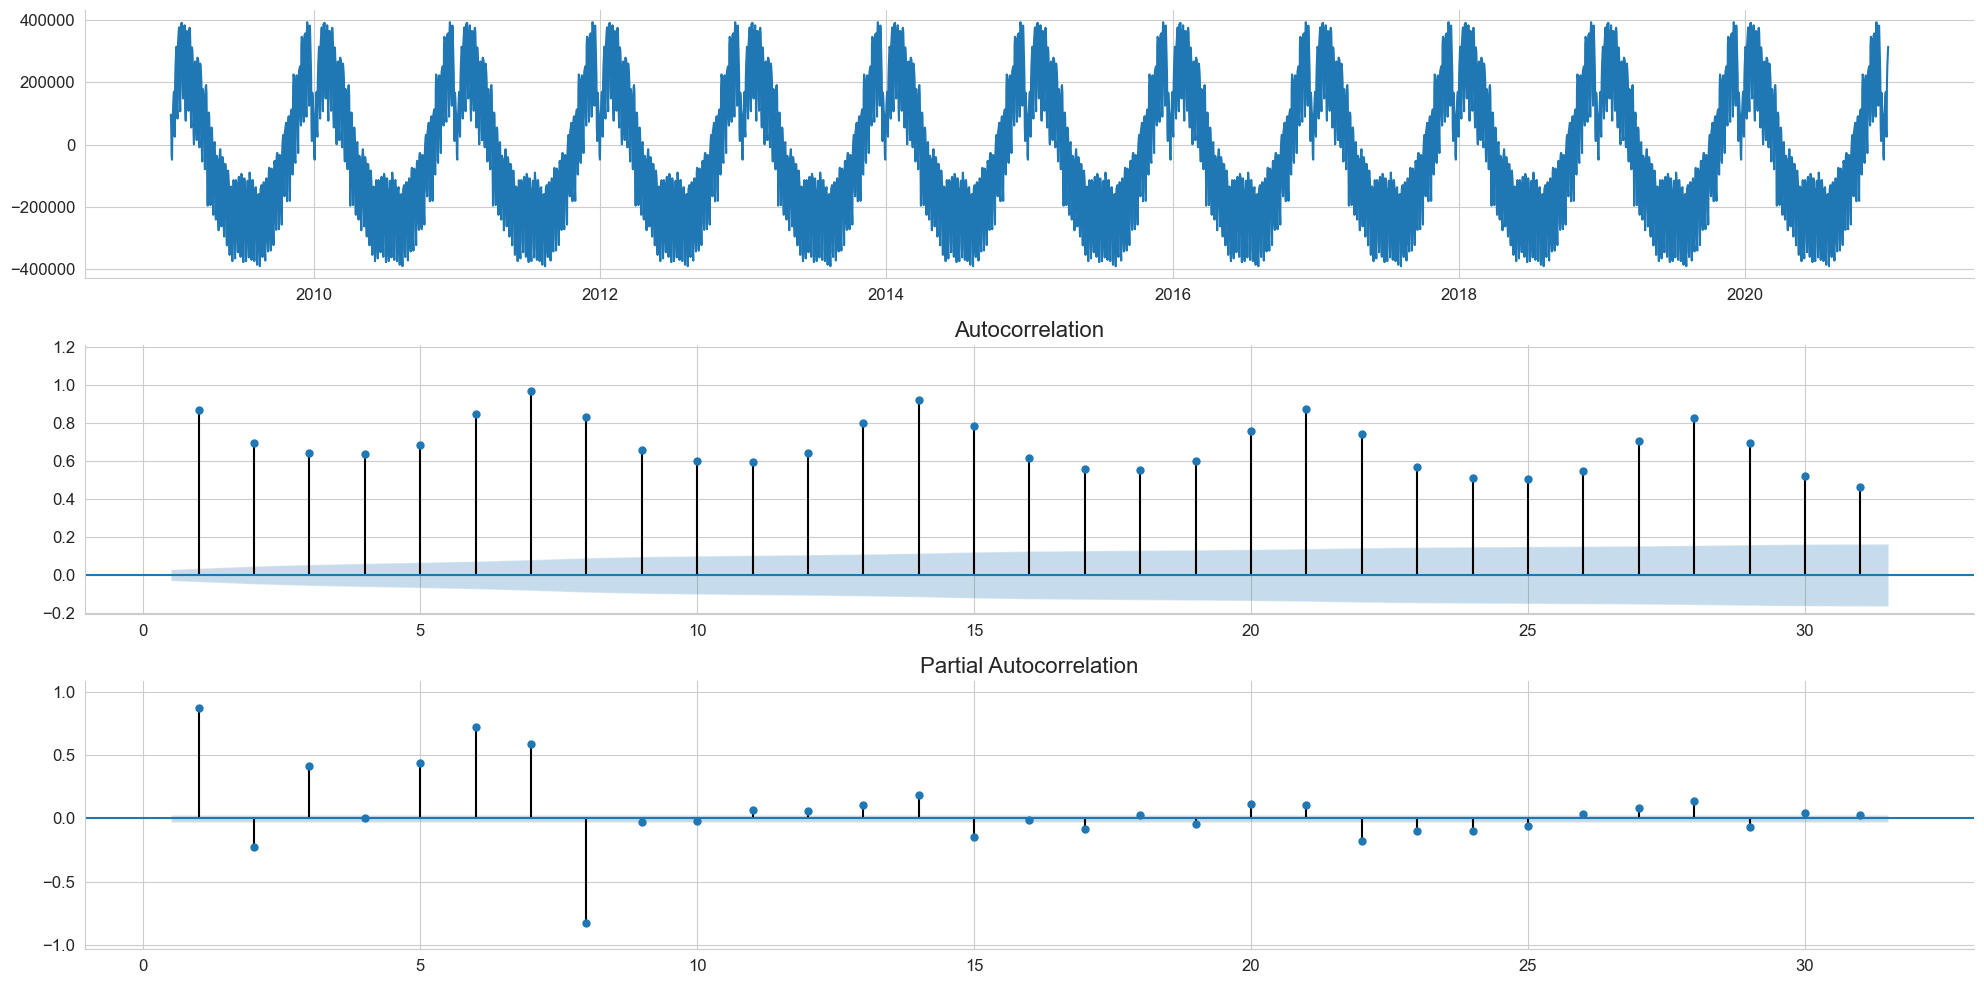

In [19]:
autocorr_plots(decompose.seasonal, lags=31)

These graphs show the same issues since the values either take many lags to fall within the confidence interval or they never do it continuously. A good first estimation is $P=3$, $Q=2$ and $s=364$. 

I know that Q should be higher, but as we will see, as I increase the values of the parameters it takes way longer to train the model as there are more parameters to compute. At first, I want a reasonable estimation that doesn't take very long to run.

<a id='model_prop'></a>
## Model proposals

In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [21]:
def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model

### Model 0 - Baseline

We start defining a baseline model, with parameters $p=q=P=Q=1$, in order to compare its performance with the other models we will propose. With this, we can measure how much the models improve as we tune the parameters.

C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Normality: val=2508.785, p=0.000
Ljung-Box: val=193.378, p=0.000
Heteroskedasticity: val=1.391, p=0.000
Durbin-Watson: d=1.95
-------------------------------------------------------------


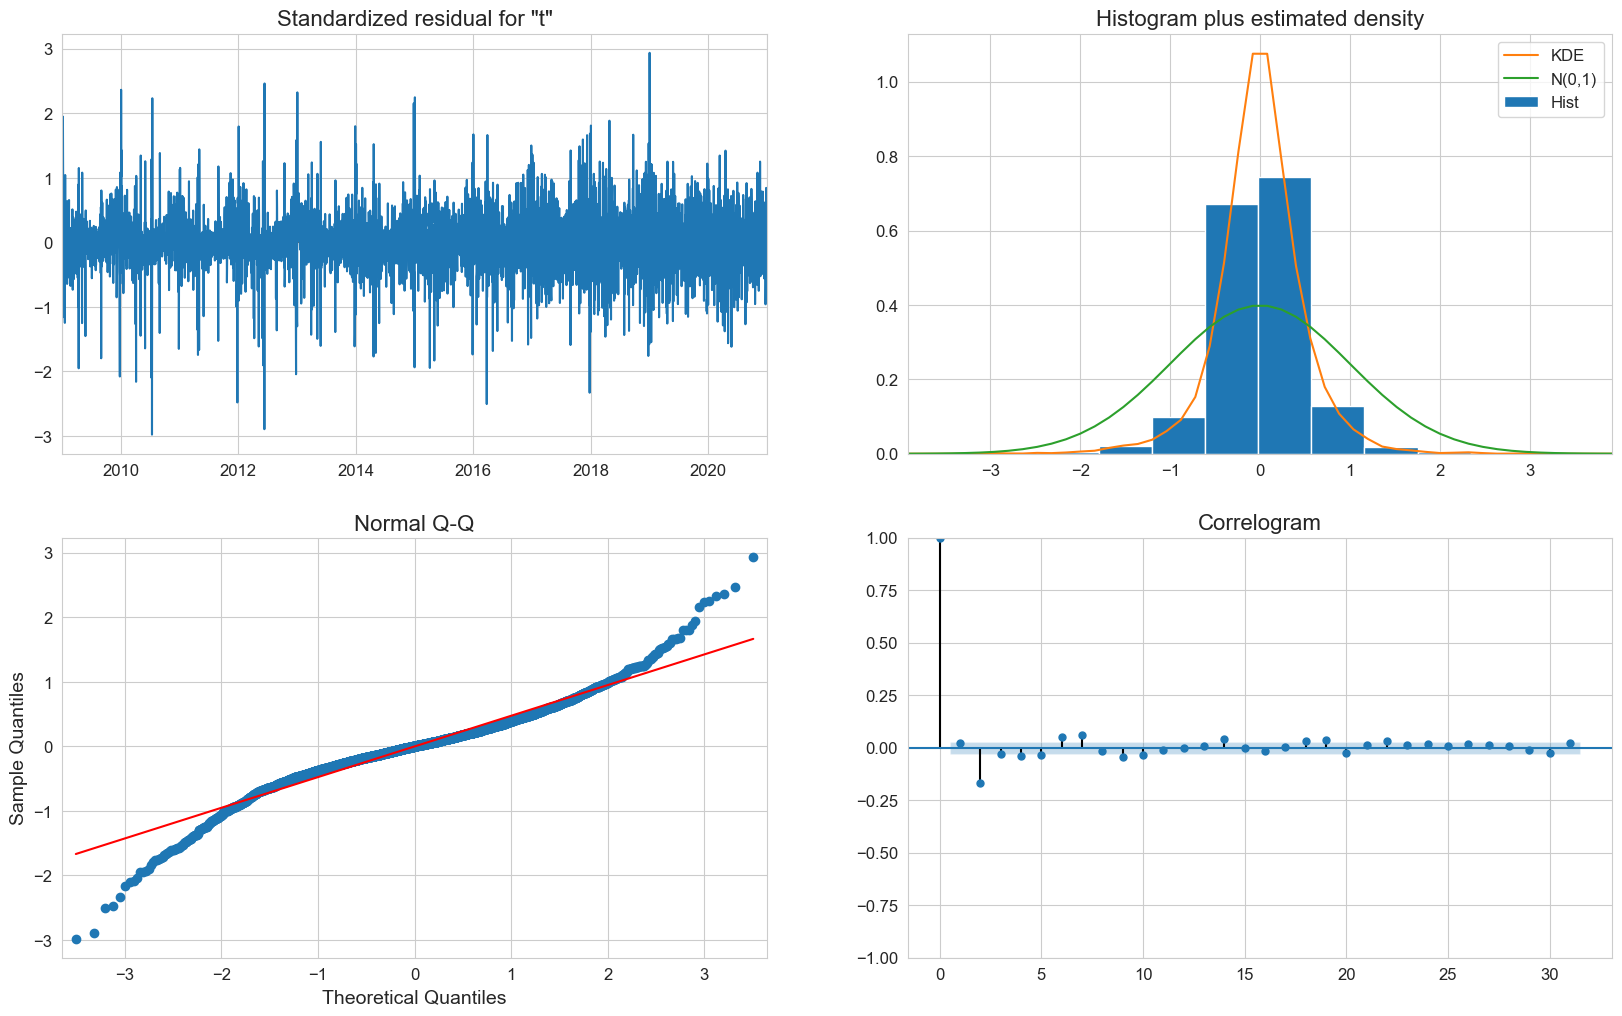

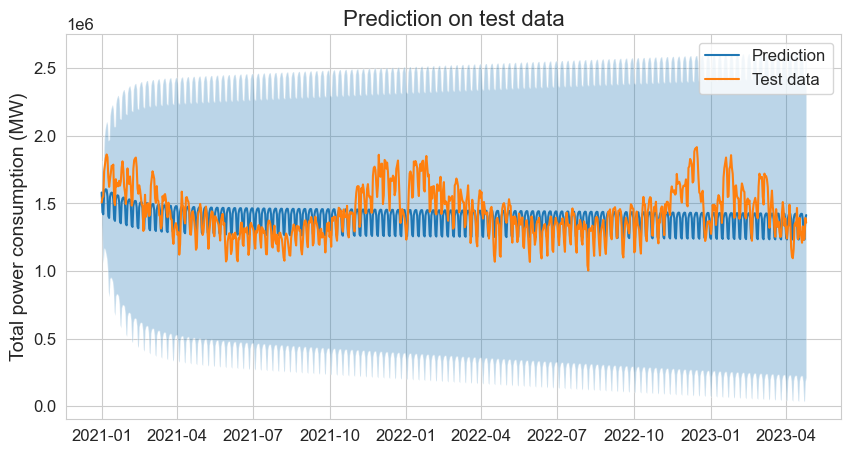

In [22]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train['tsd'], (1, 0, 1), (1, 0, 1, 7), 75, 31, test['tsd'], False
)

In [23]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

Model 0 MAPE value: 8.788663516102725
Model 0 runtime: 0:00:03.279093


### Model 1

In [24]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train['tsd'], (7, 1, 2), (3, 1, 2, 7), 50, 31, test['tsd'], False
)

ValueError: Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.

In [25]:
print(f"Model 0 MAPE value: {mape_1}")
print(f"Model 0 runtime: {execution_time_1}")

Model 0 MAPE value: 18.453949757828855
Model 0 runtime: 0:06:39.892481


### Model 2

In the diagnostic plots above, it can be seen that there is a spike at lag 7 in the autocorrelation plot. Therefore, I will set $q=7$ and run the model again:

In [ ]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train['tsd'], (7, 1, 7), (3, 1, 2, 364), 50, 31, test['tsd'], False
)

C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mpena\anaconda3\envs\py37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

Model 0 MAPE value: 11.581716915001984
Model 0 runtime: 0:08:59.193030


### Model 3

Model 2 seems to be more accurate after tuning the p and q values. To make it more accurate, I think that modifying the P or Q paramerters might be the key. I initially selected a low value of P and Q to save some time while training the models. However, my guess is that P should be higher and given the spike at lag 9 in the seasonal partial autocorrelation plot I will choose P=9. 

In [28]:
# [execution_time_3, mape_3, sarima_model_3] = create_predict_analyse(
#     train_data, (7, 1, 7), (9, 1, 2, 12), 25, 31, test_data, True
# )

I ran the model, but as you can see, the code is commented out. The model took almost 25 minutes to run (the exact output of the original run is 0:24:27.022123), even though I set the maximum number of iterations to 25. I initially saved the entire model but it was a 10 GB file... Therefore, I decided to save the graphs only. 

Despite the runtime and the complexity of the model, it actually leads to a worse prediction since the mape value is 26.2 (the exact result is 26.17452577271045).

The reality is that none of the SARIMA models perform well. They don't capture the trend and the struggle to capture the yearly seasonality. Obviously, the parameters need to be refined, but the models take too long to run to choose the optimal parameters using [pdarima](https://pypi.org/project/pmdarima/) or a similar package.